In [2]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (10.0, 8.0)}
%matplotlib inline

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.5' 

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np

from temgym_core.gaussian import GaussianRayBeta
from temgym_core.grid import Grid
from temgym_core.gaussian_taylor import evaluate_gaussian_packets_jax_scan

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

%matplotlib widget

In [3]:
abtem.config.set({"device": "cpu", "fft": "fftw"})

## Atomic model

In this section we create the atomic model. See our [walkthough](walkthrough:atomic_models) or our [tutorial](tutorials:advanced_atomic_models) on atomic models. 

We create two nanotubes with different radii using the [`nanotube`](https://wiki.fysik.dtu.dk/ase/ase/build/build.html#ase.build.nanotube) function from ASE.

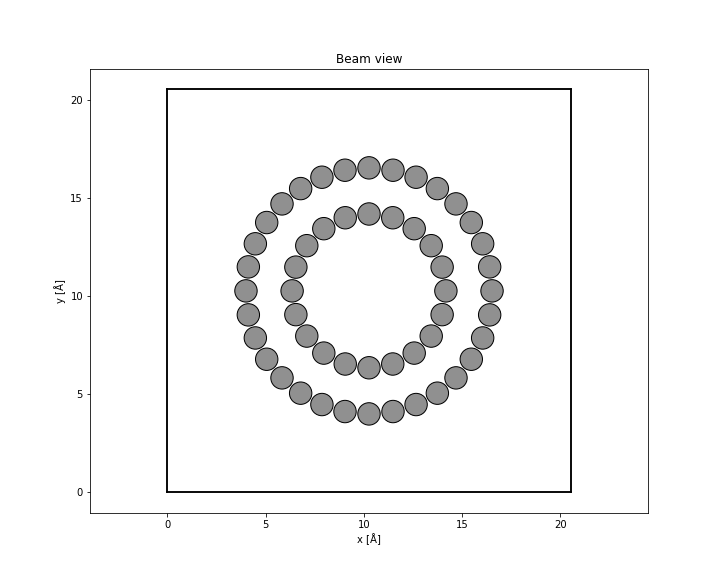

In [4]:
tube1 = ase.build.nanotube(10, 0, length=5)

tube2 = ase.build.nanotube(16, 0, length=5)

# combine the two nanotubes into a single structure
tubes = tube1 + tube2

# add vacuum in the x- and y-direction
tubes.center(vacuum=4.0, axis=(0, 1))

abtem.show_atoms(tubes, plane="xy", title="Beam view");

We rotate the nanotubes such the beam travels perpendicular to the length of the nanotubes.

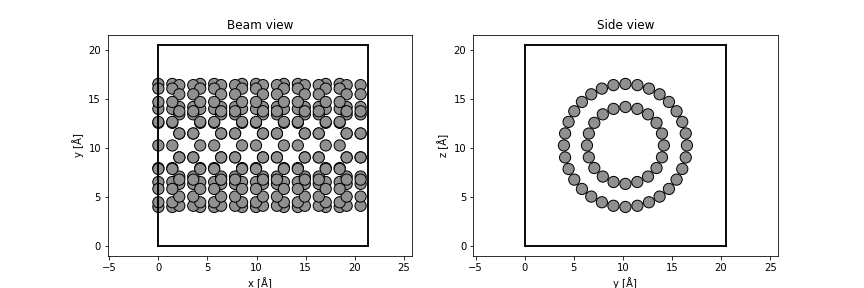

In [5]:
rotated_tubes = tubes.copy()

# rotate cell and atoms by 90 degrees around y
rotated_tubes.rotate("y", 90, rotate_cell=True)

# standardize unit cell (done automatically in an abTEM simulation)
rotated_tubes = abtem.standardize_cell(rotated_tubes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(rotated_tubes, plane="xy", ax=ax1, title="Beam view")
abtem.show_atoms(rotated_tubes, plane="yz", ax=ax2, title="Side view");

## Potential

We create an ensemble of potentials using the frozen phonon model. See our [walkthrough on frozen phonons](walkthrough:frozen_phonons). 

In [6]:
frozen_phonons = abtem.FrozenPhonons(rotated_tubes, 1, sigmas=0.1)

We create a potential from the frozen phonons model, see [walkthrough on potentials](walkthrough:potentials).

In [7]:
potential = abtem.Potential(
    frozen_phonons,
    sampling=0.2,
    projection="infinite",
    slice_thickness=1,
)


In [8]:
# Print available dimension information for the abtem Potential
# (does not re-import or redefine any existing variables)

info = {
    "extent": getattr(potential, "extent", None),
    "sampling": getattr(potential, "sampling", None),
    "shape": getattr(potential, "shape", None),
    "grid_shape": getattr(potential, "grid_shape", None),
}

# try common array/data attributes used to store the potential grid
arr = getattr(potential, "array", None) or getattr(potential, "data", None) or getattr(potential, "pot", None)
info["array_shape"] = getattr(arr, "shape", None)

for k, v in info.items():
    print(f"{k}: {v}")

extent: (21.299999999999997, 20.52619250398311)
sampling: (0.19906542056074764, 0.19928342236876806)
shape: (1, 21, 107, 103)
grid_shape: None
array_shape: None


## Wave function

We create a plane wave function at an energy of 100 keV.

In [12]:
plane_wave = abtem.PlaneWave(
    gpts=potential.gpts, extent=potential.extent, energy=100e3
)
plane_wave_array = plane_wave.build().compute().array


[########################################] | 100% Completed | 103.83 ms


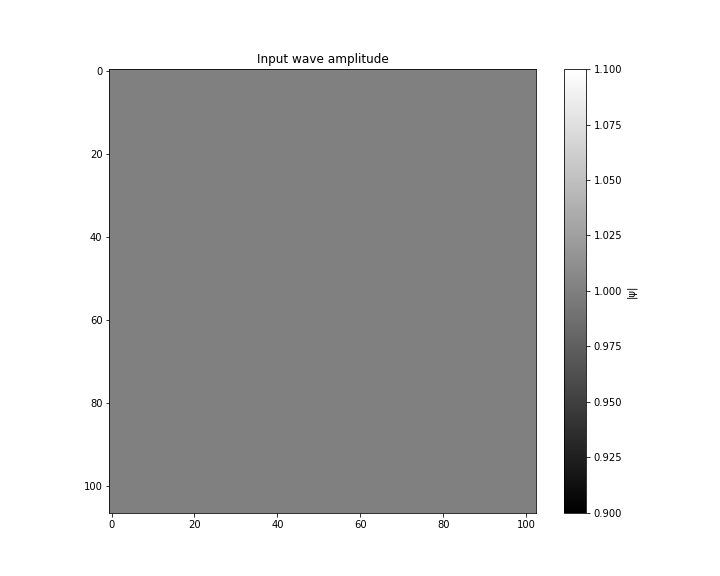

In [13]:

plt.figure()
plt.imshow(np.abs(plane_wave_array), cmap="gray")
plt.title("Input wave amplitude")
plt.colorbar(label="|ψ|")
plt.show()

We take this plane wave array, and with uniformly distributed gaussians make an approximately equivalent input wave function decomposed of gaussians.

In [15]:
shape_x, shape_y = potential.shape[2], potential.shape[3]
shape = (shape_y, shape_x)
pixel_size = (potential.sampling[1], potential.sampling[0])

input_grid = Grid()
input_grid.z = 0.0
input_grid.centre = (0.0, 0.0)
input_grid.shape = shape
input_grid.pixel_size = pixel_size
input_grid.flip_y = False
input_grid.rotation = 0.0
extent = potential.extent
grid_area = input_grid.pixel_size[0] * input_grid.pixel_size[1] * input_grid.shape[0] * input_grid.shape[1]

num_rays = shape_x * shape_y

wavelength = plane_wave.wavelength
w0 = wavelength * 10.0
lam = jnp.ones(num_rays) * wavelength
k0  = 2 * jnp.pi / lam

scale_factor = grid_area / (w0 ** 2 * num_rays * np.pi)
C0 = jnp.ones(num_rays) * (1.0 * scale_factor + 0.0j)
eta = jnp.full((num_rays, 2), 0.0 + 0.0j)

waist_func = -1j * (2.0 / (k0 * (w0 ** 2)))
eye22 = jnp.eye(2, dtype=jnp.complex128)
Qinv0 = (waist_func.astype(jnp.complex128))[:, None, None] * eye22
Qinv0 = jnp.broadcast_to(Qinv0, (num_rays, 2, 2))

gaussian_ray_xy = input_grid.coords
gaussian_ray_x = gaussian_ray_xy[..., 0].ravel()
gaussian_ray_y = gaussian_ray_xy[..., 1].ravel()
gaussian_rays = GaussianRayBeta(x=gaussian_ray_x, 
                y=gaussian_ray_y, 
                dx=jnp.zeros(num_rays), 
                dy=jnp.zeros(num_rays), 
                z=jnp.zeros(num_rays), 
                pathlength=jnp.zeros(num_rays),
                C=C0,
                eta=eta,
                Q_inv=Qinv0,
                k0=k0)
gaussian_rays = gaussian_rays.to_vector()

In [16]:
E_input = evaluate_gaussian_packets_jax_scan(gaussian_rays, input_grid, batch_size=500)

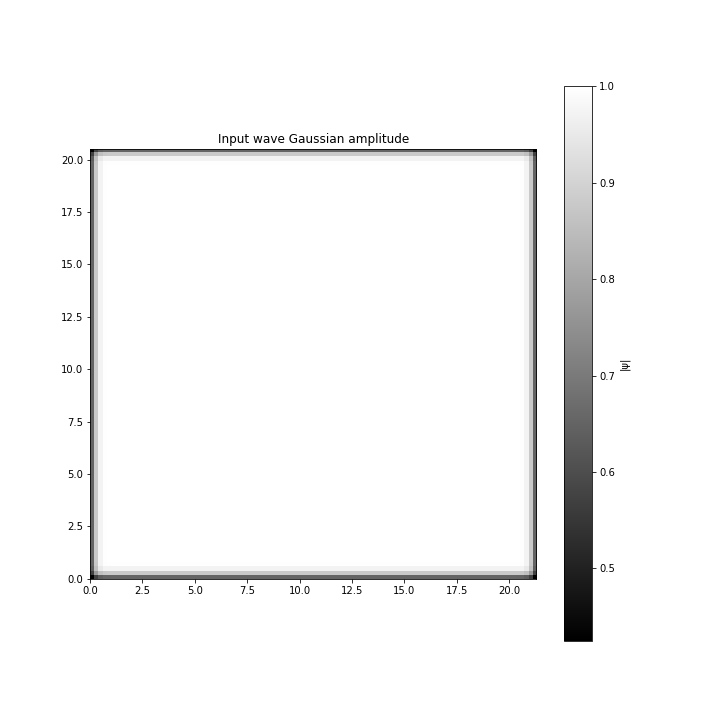

In [18]:
plt.figure(figsize = (10, 10))
plt.imshow(np.abs(E_input), cmap="gray", extent=(0, extent[0], 0, extent[1]))
plt.title("Input wave Gaussian amplitude")
plt.colorbar(label="|ψ|")


## Multislice

We run the multislice algorithm to calculate the exit waves, see our [walkthrough on multislice](walkthrough:multislice).

In [19]:
exit_wave = plane_wave.multislice(potential)

In [63]:
exit_wave.compute()

[########################################] | 100% Completed | 1.08 ss


In [64]:
measurement_ensemble = exit_wave.intensity()

measurement_ensemble.shape

(1, 107, 103)

The result is an ensemble of images, one for each frozen phonon, we average the ensemble to obtain the final image. 

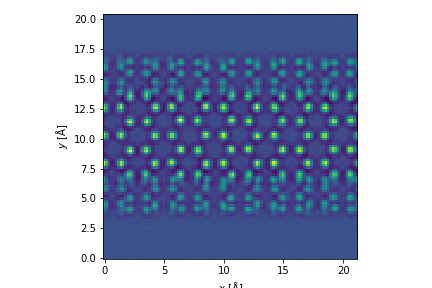

In [65]:
measurement = measurement_ensemble.mean(0)

measurement.show()

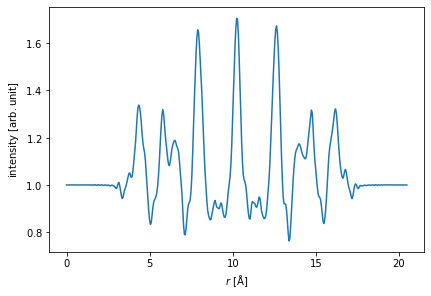

In [21]:
start = (0, 0)
end = (0, potential.extent[1])

measurement.interpolate_line(start, end).show();